In [1]:
from mmcv import collect_env
collect_env()

/home/bibireata/miniconda3/envs/cvml-env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'sys.platform': 'linux',
 'Python': '3.7.13 (default, Mar 29 2022, 02:18:16) [GCC 7.5.0]',
 'CUDA available': True,
 'GPU 0': 'NVIDIA GeForce RTX 2080',
 'CUDA_HOME': '/usr',
 'NVCC': 'Cuda compilation tools, release 10.1, V10.1.24',
 'GCC': 'gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0',
 'PyTorch': '1.6.0',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v1.5.0 (Git Hash e2ac1fac44c5078ca927cb9b90e1b3066a0b2ed0)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 10.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37,code=compute_

In [2]:
import os
import pickle

# Check pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check mmdet installation
import mmdet
print(mmdet.mmcv_version)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.6.0 True
[1, 5, 0]
10.1
GCC 7.3


### Create custom MMDetection dataset

In [4]:
DATA_PATH = '../data/presentation_data'
!tree ../data/presentation_data

../data/presentation_data
├── Ads
│   ├── Starbucks_Ad_15s_cmp.avi
│   ├── Starbucks_Ad_15s.rgb
│   ├── Starbucks_Ad_15s.wav
│   ├── Subway_Ad_15s_cmp.avi
│   ├── Subway_Ad_15s.rgb
│   └── Subway_Ad_15s.wav
├── annotation
│   ├── train141.xml
│   ├── train148.xml
│   ├── train149.xml
│   ├── train150.xml
│   ├── train157.xml
│   ├── train158.xml
│   ├── train159.xml
│   ├── train15.xml
│   ├── train167.xml
│   ├── train168.xml
│   ├── train169.xml
│   ├── train16.xml
│   ├── train175.xml
│   ├── train176.xml
│   ├── train17.xml
│   ├── train18.xml
│   ├── train19.xml
│   ├── train20.xml
│   ├── train21.xml
│   ├── train22.xml
│   ├── train239.xml
│   ├── train23.xml
│   ├── train240.xml
│   ├── train242.xml
│   ├── train247.xml
│   ├── train248.xml
│   ├── train249.xml
│   ├── train24.xml
│   ├── train250.xml
│   ├── train251.xml
│   ├── train256.xml
│   ├── train257.xml
│   ├── train25.xml
│   ├── train268.xml
│   ├── train269.xml
│   ├── train26.xml
│   ├── train270.xml
│   ├── train

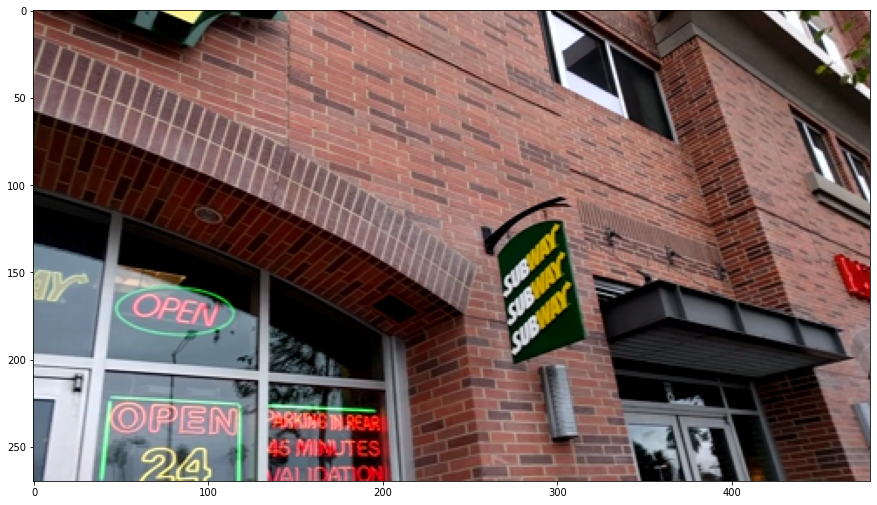

In [5]:
# Look at sample dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread(os.path.sep.join([DATA_PATH, 'images', 'train25.png']))
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [6]:
# Check label of image (will have to convert to MMDet-readable later)
!cat ../data/irl_data/annotation/train25.xml

<annotation>
	<folder>images</folder>
	<filename>train25.png</filename>
	<path>/home/bibireata/Documents/github/576-final-project/data/irl_data/images/train25.png</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>480</width>
		<height>270</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>subway</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>269</xmin>
			<ymin>125</ymin>
			<xmax>301</xmax>
			<ymax>164</ymax>
		</bndbox>
	</object>
	<object>
		<name>subway</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>270</xmin>
			<ymin>142</ymin>
			<xmax>307</xmax>
			<ymax>181</ymax>
		</bndbox>
	</object>
	<object>
		<name>subway</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>272</xmin>
			<ymin>159</ymin>
			<xmax>309</xmax>
			<ymax>199</ymax>
		</bndbox>
	<

In [8]:
import copy
import os.path as osp
import xml.etree.ElementTree as ET

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module(force=True)
class BrandImageDataset(CustomDataset):
    CLASSES = ('ae', 'hrc', 'nfl', 'sbux', 'subway', 'mcd')
    
    def load_annotations(self, ann_file):
        brand2label = {k : i for i, k in enumerate(self.CLASSES)}
        data_prefix = mmcv.list_from_file(ann_file)
        data_infos = []
        
        for prefix in data_prefix:
            annotation_f = os.path.sep.join([DATA_PATH, 'annotation',
                                             prefix + '.xml'])
            tree = ET.parse(annotation_f)
            root = tree.getroot()
            filename = root.find('path').text
            width = int(root.find('size').find('width').text)
            height = int(root.find('size').find('height').text)
            image = mmcv.imread(filename)

            data_info = dict(filename=filename, width=width, height=height)

            gt_labels = []
            gt_bboxes = []

            # load annotations
            for obj in root.iter('object'):
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                label = obj.find('name').text

                gt_labels.append(brand2label[label])
                gt_bboxes.append((xmin, ymin, xmax, ymax))

            data_anno = dict(
                bboxes = np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long)
            )

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [9]:
from sklearn.model_selection import train_test_split

# Split dataset
IMG_PATH = os.path.sep.join([DATA_PATH, 'images'])
ANN_PATH = os.path.sep.join([DATA_PATH, 'annotation'])

img_fnames = []
ann_fnames = []


for f in os.listdir(ANN_PATH):
    ann_fnames.append(f.split('.')[0])
    img_fnames.append(f.split('.')[0])
    
X_train, X_test, y_train, y_test = train_test_split(img_fnames, ann_fnames, test_size=0.2, random_state=42)

train_f = os.path.sep.join([DATA_PATH, 'train.txt'])
val_f = os.path.sep.join([DATA_PATH, 'val.txt'])

with open(train_f, 'w+') as f:
    for x in X_train:
        f.write(x + '\n')

with open(val_f, 'w+') as f:
    for x in X_test:
        f.write(x + '\n')

In [10]:
class BrandImageDatasetTest:
    def __init__(self):
        self.CLASSES = ('ae', 'hrc', 'nfl', 'sbux', 'subway', 'mcd')
    
    def load_annotations(self, ann_file):
        brand2label = {k : i for i, k in enumerate(self.CLASSES)}
        data_prefix = mmcv.list_from_file(ann_file)
        data_infos = []
        
        for prefix in data_prefix:
            annotation_f = os.path.sep.join([DATA_PATH, 'annotation',
                                             prefix + '.xml'])
            tree = ET.parse(annotation_f)
            root = tree.getroot()
            filename = root.find('path').text
            width = int(root.find('size').find('width').text)
            height = int(root.find('size').find('height').text)
            image = mmcv.imread(filename)

            data_info = dict(filename=filename, width=width, height=height)

            gt_labels = []
            gt_bboxes = []

            # load annotations
            for obj in root.iter('object'):
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                label = obj.find('name').text

                gt_labels.append(brand2label[label])
                gt_bboxes.append((xmin, ymin, xmax, ymax))

            data_anno = dict(
                bboxes = np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long)
            )

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [11]:
loader = BrandImageDatasetTest()
info = loader.load_annotations('../data/irl_data/val.txt')

/home/bibireata/miniconda3/envs/cvml-env/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [12]:
info

[{'filename': '/home/bibireata/Documents/github/576-final-project/data/irl_data/images/train249.png',
  'width': 480,
  'height': 270,
  'ann': {'bboxes': array([[116.,  51., 137.,  66.]], dtype=float32),
   'labels': array([0])}},
 {'filename': '/home/bibireata/Documents/github/576-final-project/data/irl_data/images/train257.png',
  'width': 480,
  'height': 270,
  'ann': {'bboxes': array([[41., 12., 76., 42.]], dtype=float32),
   'labels': array([0])}},
 {'filename': '/home/bibireata/Documents/github/576-final-project/data/irl_data/images/train59.png',
  'width': 480,
  'height': 270,
  'ann': {'bboxes': array([[249., 111., 266., 129.]], dtype=float32),
   'labels': array([3])}},
 {'filename': '/home/bibireata/Documents/github/576-final-project/data/irl_data/images/train251.png',
  'width': 480,
  'height': 270,
  'ann': {'bboxes': array([[ 2., 47., 18., 65.]], dtype=float32),
   'labels': array([0])}},
 {'filename': '/home/bibireata/Documents/github/576-final-project/data/irl_data/i

### Modify config

In [10]:
from mmcv import Config
cfg = Config.fromfile('../configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

In [12]:
from mmdet.apis import set_random_seed

# Modify dataset type + path
cfg.dataset_type = 'BrandImageDataset'
cfg.data_root = '../data/presentation_data'

cfg.data.test.type = 'BrandImageDataset'
cfg.data.test.data_root = '../data/presentation_data'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'BrandImageDataset'
cfg.data.train.data_root = '../data/presentation_data'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'BrandImageDataset'
cfg.data.val.data_root = '../data/presentation_data'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'images'

# modify number of classes
cfg.model.roi_head.bbox_head.num_classes = 6
# Load pretrained model to finetune
cfg.load_from = '../checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# setup working directory to save files/logs
cfg.work_dir = '../presentation_exps'

cfg.optimizer.lr = 0.02/8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')
]

cfg.device = 'cuda'

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

In [14]:
cfg.keys()

dict_keys(['model', 'dataset_type', 'data_root', 'img_norm_cfg', 'train_pipeline', 'test_pipeline', 'data', 'evaluation', 'optimizer', 'optimizer_config', 'lr_config', 'runner', 'checkpoint_config', 'log_config', 'custom_hooks', 'dist_params', 'log_level', 'load_from', 'resume_from', 'workflow', 'opencv_num_threads', 'mp_start_method', 'auto_scale_lr', 'work_dir', 'seed', 'gpu_ids', 'device'])

In [15]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
cfg.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

with open(os.path.sep.join([cfg.work_dir, 'model.pkl']),'wb') as f:
    pickle.dump(model, f)

with open(os.path.sep.join([cfg.work_dir, 'config.pkl']),'wb') as f:
    pickle.dump(cfg, f)

/home/bibireata/miniconda3/envs/cvml-env/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
2022-05-04 21:22:40,641 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-05-04 21:22:40,706 - mmdet - INFO - load checkpoint from local path: ../checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth

2022-05-04 21:23:51,303 - mmdet - INFO - Epoch [5][10/44]	lr: 2.500e-03, eta: 0:01:58, time: 0.531, data_time: 0.220, memory: 3499, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0047, loss_cls: 0.0816, acc: 96.8359, loss_bbox: 0.1353, loss: 0.2219
2022-05-04 21:23:54,445 - mmdet - INFO - Epoch [5][20/44]	lr: 2.500e-03, eta: 0:01:54, time: 0.315, data_time: 0.023, memory: 3499, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0091, loss_cls: 0.0810, acc: 97.2852, loss_bbox: 0.1542, loss: 0.2460
2022-05-04 21:23:57,741 - mmdet - INFO - Epoch [5][30/44]	lr: 2.500e-03, eta: 0:01:51, time: 0.329, data_time: 0.021, memory: 3499, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0073, loss_cls: 0.0733, acc: 97.2852, loss_bbox: 0.1517, loss: 0.2348
2022-05-04 21:24:01,034 - mmdet - INFO - Epoch [5][40/44]	lr: 2.500e-03, eta: 0:01:47, time: 0.329, data_time: 0.023, memory: 3499, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0068, loss_cls: 0.1047, acc: 96.4551, loss_bbox: 0.1587, loss: 0.2723
2022-05-04 21:24:07,663 - mmdet - IN

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 22/22, 12.3 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-05-04 21:26:01,063 - mmdet - INFO - 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| ae     | 2   | 29   | 1.000  | 1.000 |
| hrc    | 16  | 40   | 1.000  | 0.996 |
| nfl    | 2   | 8    | 1.000  | 1.000 |
| sbux   | 7   | 25   | 1.000  | 0.982 |
| subway | 9   | 48   | 1.000  | 0.730 |
| mcd    | 7   | 8    | 0.857  | 0.776 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.914 |
+--------+-----+------+--------+-------+
2022-05-04 21:26:01,065 - mmdet - INFO - Epoch(val) [12][22]	AP50: 0.9140, mAP: 0.9141


In [48]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ../brand_exps

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 63488), started 0:37:57 ago. (Use '!kill 63488' to kill it.)

### Run inference

In [9]:
%matplotlib notebook

In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def frame_from_bit_arr(bit_arr):
    IMG_WIDTH = 480
    IMG_HEIGHT = 270
    IMG_DEPTH = 3
    IMG_AREA = IMG_WIDTH * IMG_HEIGHT
    
    img = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype=np.uint8)
    
    for d in range(IMG_DEPTH):
        channel = np.reshape(bit_arr[d * IMG_AREA:(d+1) * IMG_AREA], 
                             (IMG_HEIGHT, IMG_WIDTH))
        img[:,:,d] = channel
    
    return img

def bit_arr_from_frame(frame, channel_order="bgr"):
    IMG_WIDTH = 480
    IMG_HEIGHT = 270
    IMG_DEPTH = 3
    IMG_AREA = IMG_WIDTH * IMG_HEIGHT
    
    bit_arr = np.zeros((np.prod(frame.shape),), dtype=np.uint8)
    for d in range(IMG_DEPTH):
        bit_arr[d * IMG_AREA : (d+1) * IMG_AREA] = frame[:,:,IMG_DEPTH - 1 -d].flatten()
    
    return bit_arr
    

def read_vid_frame(fpath, nframe=1):
    VID_PATH = fpath
    IMG_WIDTH = 480
    IMG_HEIGHT = 270
    IMG_DEPTH = 3
    IMG_AREA = IMG_WIDTH * IMG_HEIGHT
    
    vid_f = open(VID_PATH, 'rb')
    vid_f_size = IMG_WIDTH * IMG_HEIGHT * IMG_DEPTH
    
    # skip over undesired frames without processing
    for i in range(nframe):
        vid_f.read(vid_f_size)
    
    bit_str = vid_f.read(vid_f_size)
    bit_arr = np.frombuffer(bit_str, np.uint8)
    
    '''img = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype=np.uint8)
    
    for d in range(IMG_DEPTH):
        channel = np.reshape(bit_arr[d * IMG_AREA:(d+1) * IMG_AREA], 
                             (IMG_HEIGHT, IMG_WIDTH))
        img[:,:,d] = channel'''
        
    img = frame_from_bit_arr(bit_arr)
    
    vid_f.close()
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    return img

In [39]:
%%timeit
bit_arr_from_frame(img)

143 µs ± 452 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [40]:
%%timeit
frame_from_bit_arr(bit_arr)

134 µs ± 551 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<IPython.core.display.Javascript object>


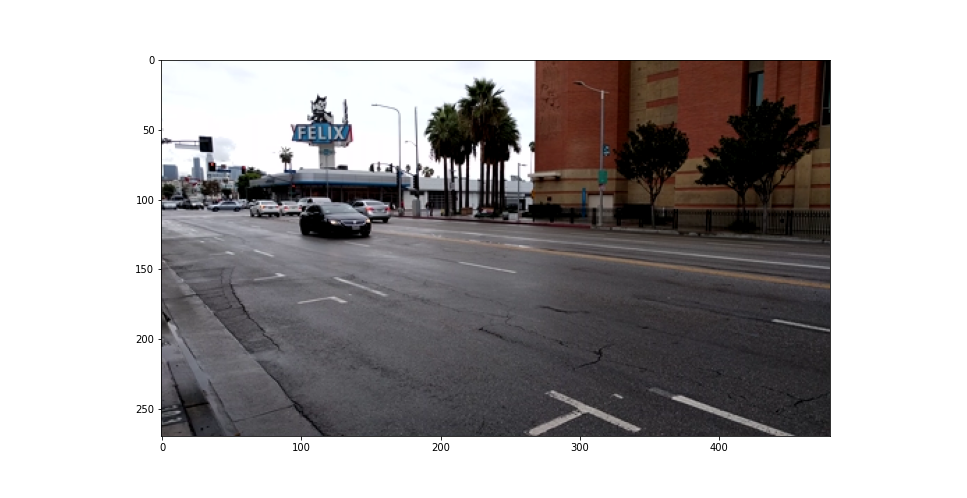

In [38]:
img = read_vid_frame('../data/dataset1/Videos/data_test1.rgb')
bit_arr = bit_arr_from_frame(img)
img_re = frame_from_bit_arr(bit_arr)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

<IPython.core.display.Javascript object>


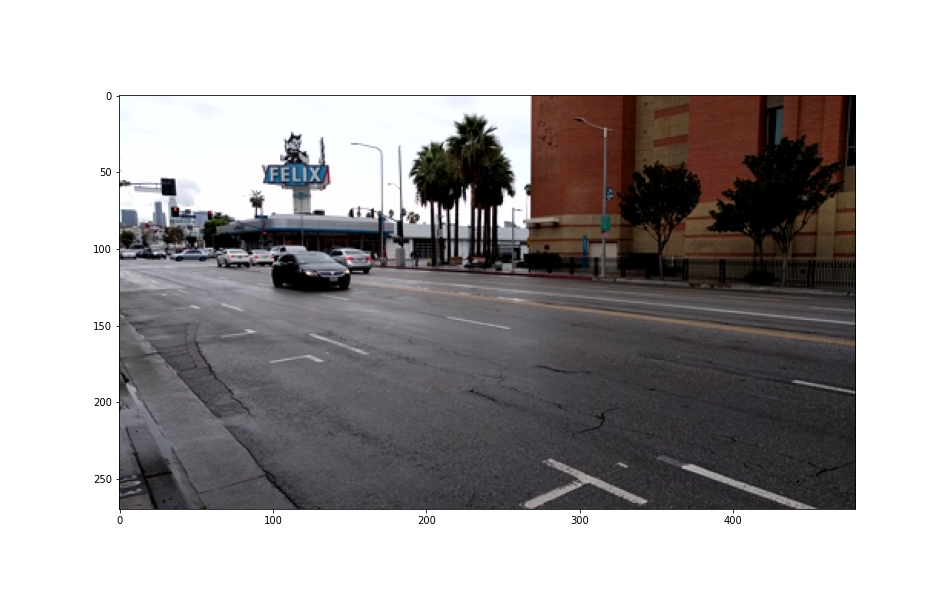

In [30]:
frame_n = 1
img = read_vid_frame('../data/dataset1/Videos/data_test1.rgb', frame_n)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [64]:
# Read model from file rather than using the one from the notebok
WORK_DIR = '../brand_exps/'
CFG_PATH = os.path.sep.join([WORK_DIR, 'config.pkl'])
MOD_PATH = os.path.sep.join([WORK_DIR, 'model.pkl'])

read_model = pickle.load(open(MOD_PATH,'rb'))
read_cfg = pickle.load(open(CFG_PATH,'rb'))

read_model.cfg=read_cfg

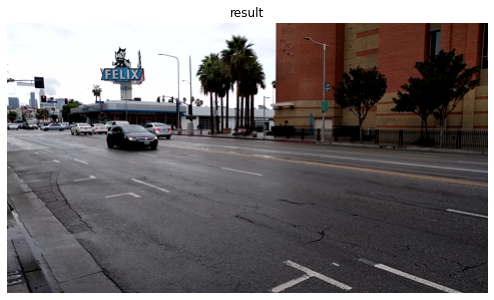

In [65]:
# Run inference with loaded model rather than notebook's model
img = mmcv.imread(img, channel_order="bgr")

result = inference_detector(read_model, img)
show_result_pyplot(read_model, img, result)

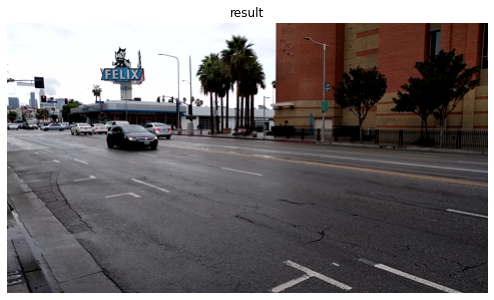

In [46]:
from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

#img = mmcv.imread('../data/irl_data/images/train167.png')
img = mmcv.imread(img, channel_order="rgb")

detector_model = model
detector_model.cfg = cfg
result = inference_detector(detector_model, img)
show_result_pyplot(detector_model, img, result)

In [44]:
result

[array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32)]

In [19]:
%%timeit
result = inference_detector(detector_model, img)

78.7 ms ± 425 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
len(result)

6

In [29]:
result

[array([[1.7148820e+02, 1.4925311e+02, 1.8700620e+02, 1.7745891e+02,
         7.8086197e-02],
        [2.8107458e+02, 1.5681151e+02, 3.6204898e+02, 2.3474791e+02,
         7.3456988e-02],
        [3.7710013e+02, 2.1700638e+02, 3.9105801e+02, 2.2901804e+02,
         5.9792247e-02]], dtype=float32),
 array([[2.8680377e+02, 1.5553745e+02, 3.6694333e+02, 2.3540556e+02,
         2.5407258e-01]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.7991809e+02, 1.5504456e+02, 3.6071744e+02, 2.4591167e+02,
         9.6958451e-02]], dtype=float32),
 array([[2.7913947e+02, 1.6226018e+02, 3.5964484e+02, 2.2988934e+02,
         3.3108175e-01],
        [1.7263121e+02, 1.5252571e+02, 1.8680156e+02, 1.7676712e+02,
         1.6901381e-01],
        [3.7750616e+02, 2.1795180e+02, 3.9005719e+02, 2.2682317e+02,
         9.7138278e-02],
        [2.0106447e+02, 2.0593136e+01, 3.6662759e+02, 1.2438090e+02,
         8.3849423e-02],
        [3.7243228e+02, 1.7606628e+02, 3.9505667e+02, 2.044598